# Session 0

## 1. Matmul

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import operator

In [4]:
def test(a, b, cmp, cname=None):
    if cname is None:
        cname = cmp.__name__
    assert cmp(a, b), f"{cname}:\n{a}\n{b}"

def test_eq(a, b):
    test(a, b, operator.eq, '==')

In [10]:
test_eq(int('13'), 13)

## Get Data

In [12]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL = 'http://deeplearning.net/data/mnist/mnist.pkl'

In [13]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/home/jovyan/.fastai/data/mnist.pkl.gz')

In [14]:
with gzip.open(path, 'rb') as f:
    ((X_train, y_train), (X_val, y_val), _) = pickle.load(f, encoding='latin-1')

In [17]:
X_train, y_train, X_val, y_val = map(tensor, (X_train, y_train, X_val, y_val))

Numpy arrays aren't allowed in the course, so we'll be using `torch.tensor` instead:

In [19]:
n, c = X_train.shape
X_train, X_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

Let's add some tests:

In [20]:
assert n==X_train.shape[0]==50000

In [21]:
test_eq(c, 28*28)

In [22]:
test_eq(y_train.min(), 0)

In [23]:
test_eq(y_train.max(), 9)

Let's plot a sample image:

In [24]:
img = X_train[0]

In [25]:
img.view(28, 28).type()

'torch.FloatTensor'

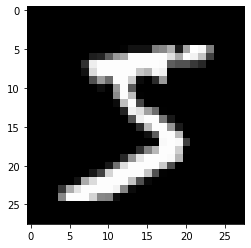

In [26]:
plt.imshow(img.view(28,28), cmap='gray')

## Initial Python Model 

We have $X \in \Bbb{R}^{m \times 784}$ and because we want a probability distribution over 10 digits, $W \in \Bbb{R}^{784 \times 10}$ and the bias $b \in \Bbb{R}^{m \times 10}$ (broadcasted).

In [27]:
weights = torch.randn(784, 10)

In [29]:
bias = torch.zeros(10)

### Matrix Multiplication

In [49]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i,k] * b[k,j]
    return c

Let's grab the first five rows of the validation set:

In [99]:
m1 = X_val[:5]
m2 = weights

In [100]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [53]:
%time t1 = matmul(m1, m2)

CPU times: user 812 ms, sys: 0 ns, total: 812 ms
Wall time: 807 ms


In [38]:
t1.shape

torch.Size([5, 10])

This is kind of slow because it took us about 1s for 5 rows and we have 50,000 rows in the training set.

50,000 seconds ~ 14 hours for a single matrix multiplication in Python!

Let's see if we can speed this up by 50k times:

- The way to make things faster is to remove Python.
- So we pass our computation down something other than Python (like PyTorch's **Aten**).

We take advantage of elementwise operations:

### Elementwise ops

Examples of elementwise operations (usually +, -, <, >, ==, !=, *):

In [39]:
a = tensor([10, 6., -4])
b = tensor([2., 8, 7])
a, b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [40]:
a + b  # element-wise addition

tensor([12., 14.,  3.])

In [41]:
(a < b).float().mean()

tensor(0.6667)

In [42]:
m = tensor([[1., 2, 3], [4, 5, 6], [7, 8, 9]])
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Let's calculate the **Frobenius Norm** of a matrix:

$$||A||_{F}=(\sum_{i,j=1}^{n}|a_{i,j}|^2)^{1/2}$$

More like:

$$||A||_{F}=\sqrt{\sum_{i=1}^{n}\sum_{j=1}^{n}|a_{i,j}|^2}$$

It's basically:

In [46]:
(m*m).sum().sqrt()  # element-wise multiplication, permittable

tensor(16.8819)

### Elementwise Multiplication

We exploit PyTorch's element-wise multiplication performance to remove the loop responsible for calculating $c[i,j]$ by row-to-column multiplication:

In [57]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i,j] = (a[i,:] * b[:,j]).sum()  # this is running in C
    return c

In [58]:
%timeit -n 10 _=matmul(m1, m2)

1.18 ms ± 36.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [56]:
812/1.23

660.1626016260162

Let's check if the two implementations calculate the same number (roughly):

In [59]:
def near(a, b):
    return torch.allclose(a, b, rtol=1e-3, atol=1e-5)

def test_near(a, b):
    test(a, b, near)

In [60]:
test_near(t1, matmul(m1, m2))

## Broadcasting

The term **broadcasting** describes how arrays of different shapes are treated during arithmetic operations. The term broadcasting was first used by NumPy.

### Broadcasting with a scalar

In [61]:
a

tensor([10.,  6., -4.])

In [62]:
a > 0

tensor([ True,  True, False])

Other examples of broadcasting with a scalar:

In [63]:
a + 1

tensor([11.,  7., -3.])

In [64]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [65]:
2 * m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

The special thing about it that when we do it, we're not running it at Python speed but at C (for CPUs) or CUDA (for GPU) speed. Steps:

1. Broadcast (reshape) 1 of the tensors to be compatible with the other.
2. Do element-wise computations.

### Broadcasting a vector to a matrix 

In [66]:
c = tensor([10., 20, 30])
c

tensor([10., 20., 30.])

In [67]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [68]:
m.shape, c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [69]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

We don't really copy the rows, but it looks as if we did. In fact the rows are given a stride of 0.

In [71]:
t = c.expand_as(m)
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [72]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [73]:
t.storage()  # !

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

In [75]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

You can index with the special value \[None\] or use `.unsqueeze()` to convert a 1-dimensional array into a 2-dimensional array: 

In [79]:
c.unsqueeze(0)  # adds dimensions at axis 0

tensor([[10., 20., 30.]])

In [82]:
c.unsqueeze(1)  # adds dimensions at axis 1

tensor([[10.],
        [20.],
        [30.]])

In [83]:
c.shape, c.unsqueeze(0).shape, c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [84]:
c.shape, c[None, :].shape, c[:, None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

You can always skip trailling ':', and '...' means 'all preceeding dimensions' 

In [85]:
c[None].shape, c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [88]:
c[:,None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [89]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

### Matmul with Broadcasting

In [115]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        # HOMEWORK — WHY THIS WORK?
        c[i] = (a[i].unsqueeze(-1) * b).sum(dim=0)  # exploited element-wise multiplication + broadcasting to run in C.
    return c

In [116]:
%timeit -n 10 _=matmul(m1, m2)

257 µs ± 21.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [120]:
885000/287

3083.623693379791

In [121]:
test_near(t1, matmul(m1, m2))

### Broadcasting Rules

Once you get to higher order tensors, broadcasting can become complicated, so we present the following rules:

In [122]:
c[None,:]

tensor([[10., 20., 30.]])

In [123]:
c[None,:].shape

torch.Size([1, 3])

In [124]:
c[:,None].shape

torch.Size([3, 1])

In [125]:
c[None,:] * c[:, None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [126]:
c[None] > c[:,None]

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

When operating on two arrays/tensors, NumPy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward.

two dimensions are compatible if:
- They are equal
- One of them is 1, in that case that dimension is broadcasted to make it the same size.

Any two tensors aren't required to have the same rank. The missing dimensions are automatically replaced by $1$s.

### Einstein Summation

Enstein summation (`einsum`) is a compact representation for combining porducts and sums in a general way:

> The subscripts is a comma-separated string of subscript labels, where each label refers to a dimension of the corresponding operand. 
> Whenever a label is repeated it is summed, so `np.einsum('i,i', a, b)` is equivalent to `np.inner(a,b)`.
> If a label appears only once, It's not summed, so `np.einsum('i', a)` produces a view of `a` with no changes.

In [129]:
def matmul(a, b):
    return torch.einsum('ik,kj->ij', a, b)

In [132]:
%timeit -n 10 _=matmul(m1, m2)

60.2 µs ± 7.92 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [134]:
885000/60

14750.0

### PyTorch op

We can use PyTorch's function `.matmul()` for matrix multiplication.

In [138]:
%timeit -n 10 _=torch.matmul(m1, m2)

10.3 µs ± 4.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [139]:
885000/10

88500.0

It's much faster because it break the matrix into smaller parts and carry it as it does calculating, and by doing that it doesn't have to request blocks from memory as frequently.

PyTorch push these kind of tasks to BLAS (Basic Linear Algebra Subprograms), companies such as Intel & NVIDIA provide their own implementations of BLAS.

And this is why **We need to do better**.

In [140]:
t2 = m1@m2  # the matrix multiplication operator with added flexibility

In [141]:
test_near(t1, t2)

In [142]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

## 2. The Forward & Backward Passes

Let's create a function to get the data:

In [143]:
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((X_train, y_train), (X_val, y_val), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (X_train, y_train, X_val, y_val))

def normalize(x, m, s):
    return (x-m)/s

In [144]:
X_train, y_train, X_val, y_val = get_data()

In [145]:
train_mean, train_std = X_train.mean(), X_train.std()
train_mean, train_std

(tensor(0.1304), tensor(0.3073))

In [146]:
X_train = normalize(X_train, train_mean, train_std)
X_val = normalize(X_val, train_mean, train_std)

In [148]:
train_mean, train_std = X_train.mean(), X_train.std()
train_mean, train_std

(tensor(-3.0466e-06), tensor(1.))

Now our mean is very close to 9 and out standard deviation is exactly 1. 

In [149]:
def test_near_zero(a, tol=1e-3):
    assert a.abs() < tol, f"Near zero: {a}"

In [150]:
test_near_zero(X_train.mean())
test_near_zero(1 - X_train.std())

In [151]:
n, m = X_train.shape
c = y_train.max() + 1 
n, m, c

(50000, 784, tensor(10))

## Foundations version

### Basic Architecture

To simplify things, we will consider this problem a regression one:
- 1 output
- Mean Squared Error as a loss function

In [155]:
# num_hidden
nh = 50

In [167]:
w1 = torch.randn(m, nh)/math.sqrt(m)  # the thing that matters in weight initialization
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1)/math.sqrt(nh)
b2 = torch.zeros(1)

We divide by $\sqrt{rows}$ to ensure $XW$ has a mean of $0$ & a standard deviation of $1$ (HOMEWORK: PROVE IT).

This is a simplified version of what PyTorch calls Kaiming initialization.

In [168]:
test_near_zero(w1.mean())
test_near_zero(w1.std()-1/math.sqrt(m))

In [169]:
# we forget to check if our training scaling params fit with X_val
X_val.mean(), X_val.std()

(tensor(-0.0059), tensor(0.9924))

How we initialize things is really important.

Let's create the linear application:

In [170]:
def lin(x, w, b):
    return x@w + b

In [171]:
t = lin(X_val, w1, b1)

In [172]:
t.mean(), t.std()

(tensor(-0.0309), tensor(0.9903))

Let's next define the activation function, ReLU, which replaces all negatives values with zeros:

In [174]:
def relu(x):
    return x.clamp_min(0.)

In [175]:
t = relu(lin(X_val, w1, b1))

But now $ReLU(.)$ shifted the distribution of values:

In [176]:
t.mean(), t.std()

(tensor(0.3747), tensor(0.5523))

Paper References:

> [Delving deep into rectifiers: Surpassing human-level performance on imagenet classification](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf).

> [Understanding the difficulty of training deep feedforward neural networks](http://www.jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf?hc_location=ufi).

- Notes on initialization
    - We have two types of initialization: Glorot/Bengio Or Kaiming.
    - If networks sample filter weights from the gaussian distribution, they tend to not train very well.
    - Bengio's appraoch doesn't account for the effect of the relu function we applied.
    - say you have 8 conv layers with Glorot initialization and you know that std will be halved for each forward-prop, variance will reach 0 by the end.
    - Kaiming proposition is to have a 2 instead of 1 on the top of the factor multiplied with the output of the linear application:

$$std=\sqrt{\frac{2}{(1+a^{2}) \times fan\_in}}$$

        - The negative slope of the rectifier used after this layer (0 for ReLU by default).
 
Let's implement Kiming initialization for ReLU:

In [193]:
w1 = torch.randn(m, nh)*math.sqrt(2/m)

In [194]:
w1.mean(), w1.std()

(tensor(-0.0002), tensor(0.0505))

In [195]:
t = relu(lin(X_val, w1, b1))

In [196]:
t.mean(), t.std()

(tensor(0.5810), tensor(0.8423))

The results are now better (not that much for $\mu$ tbh).
Naturally the mean will never reach zero since we deleted negative half of the output value distribution.

HOMEWORK: READ KAIMING's 2.2 -> BACKPROPAGATION CASE.

Since we implemented kliming initialization, let's use its PyTorch version:

In [197]:
from torch.nn import init

In [200]:
w1 = torch.randn(m, nh)

In [201]:
init.kaiming_normal_(w1, mode='fan_out')

tensor([[ 0.0083,  0.0325, -0.0242,  ..., -0.1040,  0.0511,  0.0909],
        [ 0.0410,  0.0294, -0.0160,  ...,  0.0180, -0.0127,  0.0407],
        [-0.0586, -0.0216,  0.0506,  ..., -0.0551,  0.0168,  0.0065],
        ...,
        [ 0.0883, -0.1014, -0.0398,  ..., -0.0512,  0.1129, -0.0944],
        [-0.0128,  0.0059, -0.0093,  ..., -0.0124, -0.0025,  0.0377],
        [ 0.0802, -0.0521,  0.0351,  ...,  0.0271, -0.0614, -0.0427]])

In [203]:
t = relu(lin(X_val, w1, b1))

In [204]:
t.mean(), t.std()

(tensor(0.5586), tensor(0.8106))

We needed to provide `fan_out` and not `fan_in` because pytorch creates weights with reversed shapes:

In [206]:
w1.shape

torch.Size([784, 50])

In [207]:
import torch.nn

In [208]:
torch.nn.Linear(in_features=m, out_features=nh).weight.shape

torch.Size([50, 784])

To understand things you need to read some of the source code:

In [209]:
torch.nn.Linear.forward??

Signature: torch.nn.Linear.forward(self, input)
Docstring:
Defines the computation performed at every call.

Should be overridden by all subclasses.

.. note::
    Although the recipe for forward pass needs to be defined within
    this function, one should call the :class:`Module` instance afterwards
    instead of this since the former takes care of running the
    registered hooks while the latter silently ignores them.
Source:   
    def forward(self, input):
        return F.linear(input, self.weight, self.bias)
File:      /opt/conda/lib/python3.7/site-packages/torch/nn/modules/linear.py
Type:      function


In [212]:
torch.nn.functional.linear??

Signature: torch.nn.functional.linear(input, weight, bias=None)
Source:   
def linear(input, weight, bias=None):
    # type: (Tensor, Tensor, Optional[Tensor]) -> Tensor
    r"""
    Applies a linear transformation to the incoming data: :math:`y = xA^T + b`.

    Shape:

        - Input: :math:`(N, *, in\_features)` where `*` means any number of
          additional dimensions
        - Weight: :math:`(out\_features, in\_features)`
        - Bias: :math:`(out\_features)`
        - Output: :math:`(N, *, out\_features)`
    """
    if input.dim() == 2 and bias is not None:
        # fused op is marginally faster
        ret = torch.addmm(bias, input, weight.t())
    else:
        output = input.matmul(weight.t())
        if bias is not None:
            output += bias
        ret = output
    return ret
File:      /opt/conda/lib/python3.7/site-packages/torch/nn/functional.py
Type:      function


Now we know why, because PyTorch doesn't do a direct matrix multiplication but used the transpose of the weight matrix before calculating the transformation.

Let's look at how PyTorch's calculate convolutions:

In [218]:
torch.nn.modules.conv._ConvNd.reset_parameters??

Signature: torch.nn.modules.conv._ConvNd.reset_parameters(self)
Docstring: <no docstring>
Source:   
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)
File:      /opt/conda/lib/python3.7/site-packages/torch/nn/modules/conv.py
Type:      function


Let's try another activation function that helps $\mu(out)\approx 0$:

In [219]:
def relu(x):
    return x.clamp_min(0.) - 0.5

In [220]:
# kaiming init w/ new activation
w1 = torch.randn(m, nh)*math.sqrt(2./m)
t1 = relu(lin(X_val, w1, b1))
t1.mean(), t1.std()

(tensor(0.1066), tensor(0.8336))

This is better, we have a mean closer to 0 and the standard deviation is still close to 1 because of kaiming initialization (Activation also increases variance).

Now we have all elements to do a forward pass:

In [221]:
def model(xb):
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    l3 = lin(l2, w2, b2)
    return l3

In [222]:
%timeit -n 10 _=model(X_val)

3.52 ms ± 674 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [224]:
assert model(X_val).shape==torch.Size([X_val.shape[0], 1])

### Loss Function: MSE

In [226]:
model(X_val).shape

torch.Size([10000, 1])

We need a `squeeze()` to get rid of that trailing 1:

In [228]:
def mse(output, targ):
    return (output.squeeze(-1) - targ).pow(2).mean()

In [230]:
y_train, y_valid = y_train.float(), y_val.float()

In [231]:
preds = model(X_val)

In [232]:
preds.shape

torch.Size([10000, 1])

In [233]:
mse(preds, y_val)

tensor(35.8137)

### Gradients and Backward Pass

HOMEWORK: UNDERSTAND THE FOLLOWING.

In [235]:
def mse_grad(inp, targ): 
    # grad of loss with respect to output of previous layer
    inp.g = 2. * (inp.squeeze() - targ).unsqueeze(-1) / inp.shape[0]  # shape[0] for the sample count

In [236]:
def relu_grad(inp, out):
    # grad of relu with respect to input activations
    inp.g = (inp>0).float() * out.g

In [237]:
def lin_grad(inp, out, w, b):
    # grad of matmul with respect to input
    inp.g = out.g @ w.t()
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)

In [239]:
def forward_and_backward(inp, targ):
    # forward pass:
    l1 = inp @ w1 + b1
    l2 = relu(l1)
    out = l2 @ w2 + b2
    # we don't actually need the loss in backward!
    loss = mse(out, targ)
    
    # backward pass:
    mse_grad(out, targ)
    lin_grad(l2, out, w2, b2)
    relu_grad(l1, l2)
    lin_grad(inp, l1, w1, b1)

We only need the loss to report, it's not actually needed as much as its gradient is.

Let's do forward & backward passes:

In [240]:
forward_and_backward(X_train, y_train)

Let's save the gradients so we cab use them for the optimizer:

In [242]:
# save for testing against later
w1g = w1.g.clone()
w2g = w2.g.clone()
b1g = b1.g.clone()
b2g = b2.g.clone()
ig  = X_train.g.clone()

We cheat a little bit and use PyTorch's autograd to check our results: 

In [245]:
xt2 = X_train.clone().requires_grad_(True)
w12 = w1.clone().requires_grad_(True)
w22 = w2.clone().requires_grad_(True)
b12 = b1.clone().requires_grad_(True)
b22 = b2.clone().requires_grad_(True)

In [246]:
def forward(inp, targ):
    # forward pass:
    l1 = inp @ w12 + b12
    l2 = relu(l1)
    out = l2 @ w22 + b22
    # we don't actually need the loss in backward!
    return mse(out, targ)

In [247]:
loss = forward(xt2, y_train)

In [248]:
loss.backward()

In [253]:
test_near(w22.grad, w2g)
test_near(b22.grad, b2g)
test_near(w12.grad, w1g)
test_near(b12.grad, b1g)
test_near(xt2.grad, ig)

# Refactor Model

## Layers as classes

In [255]:
class Relu():
    def __call__(self, inp):  # forward, runs with Relu(in)
        self.inp = inp
        self.out = inp.clamp_min(0.) - 0.5
        return self.out
    
    def backward(self): 
        self.inp.g = (self.inp>0).float() * self.out.g

In [256]:
class Lin():
    def __init__(self, w, b): 
        self.w, self.b = w, b
        
    def __call__(self, inp):
        self.inp = inp
        self.out = inp @ self.w + self.b
        return self.out
    
    def backward(self):
        self.inp.g = self.out.g @ self.w.t()
        # Creating a giant outer product, just to sum it, is inefficient!
        self.w.g = (self.inp.unsqueeze(-1) * self.out.g.unsqueeze(1)).sum(0)
        self.b.g = self.out.g.sum(0)

In [257]:
class Mse():
    def __call__(self, inp, targ):
        self.inp = inp
        self.targ = targ
        self.out = (inp.squeeze() - targ).pow(2).mean()
        return self.out
    
    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

In [259]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: 
            x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): 
            l.backward()

Let's test our refactored implementation:

In [261]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model(w1, b1, w2, b2)

In [263]:
%time loss = model(X_train, y_train)

CPU times: user 144 ms, sys: 0 ns, total: 144 ms
Wall time: 25.4 ms


In [264]:
%time model.backward()

CPU times: user 5.32 s, sys: 5.08 s, total: 10.4 s
Wall time: 1.92 s


We can notice the 2s on the backward pass, which is slow.

In [266]:
test_near(w2g, w2.g)
test_near(b2g, b2.g)
test_near(w1g, w1.g)
test_near(b1g, b1.g)
test_near(ig, X_train.g)

Let's get rid of repeated code:

### Module.forward()

In [270]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self): 
        raise Exception('not implemented')

    def backward(self): 
        self.bwd(self.out, *self.args)

In [271]:
class Relu(Module):
    def forward(self, inp): 
        return inp.clamp_min(0.)-0.5
    
    def bwd(self, out, inp): 
        inp.g = (inp>0).float() * out.g

In [273]:
class Lin(Module):
    def __init__(self, w, b): 
        self.w,self.b = w,b
        
    def forward(self, inp): 
        return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = torch.einsum("bi,bj->ij", inp, out.g)
        self.b.g = out.g.sum(0)

In [274]:
class Mse(Module):
    def forward (self, inp, targ): 
        return (inp.squeeze() - targ).pow(2).mean()
    
    def bwd(self, out, inp, targ): 
        inp.g = 2*(inp.squeeze()-targ).unsqueeze(-1) / targ.shape[0]

In [275]:
class Model():
    def __init__(self):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [278]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model()

In [279]:
%time loss = model(X_train, y_train)

CPU times: user 136 ms, sys: 0 ns, total: 136 ms
Wall time: 37 ms


In [280]:
%time model.backward()

CPU times: user 312 ms, sys: 100 ms, total: 412 ms
Wall time: 133 ms


In [281]:
test_near(w2g, w2.g)
test_near(b2g, b2.g)
test_near(w1g, w1.g)
test_near(b1g, b1.g)
test_near(ig, X_train.g)

### Without Einsum

In [283]:
class Lin(Module):
    def __init__(self, w, b): 
        self.w,self.b = w,b
        
    def forward(self, inp): 
        return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = inp.t() @ out.g
        self.b.g = out.g.sum(0)

In [284]:
w1.g,b1.g,w2.g,b2.g = [None]*4
model = Model()

In [285]:
%time loss = model(X_train, y_train)

CPU times: user 152 ms, sys: 0 ns, total: 152 ms
Wall time: 25.3 ms


In [286]:
%time model.backward()

CPU times: user 276 ms, sys: 116 ms, total: 392 ms
Wall time: 161 ms


In [287]:
test_near(w2g, w2.g)
test_near(b2g, b2.g)
test_near(w1g, w1.g)
test_near(b1g, b1.g)
test_near(ig, X_train.g)

Wrap it up:

### nn.Linear & nn.Module

In [289]:
from torch import nn

In [290]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        self.loss = mse
        
    def __call__(self, x, targ):
        for l in self.layers: 
            x = l(x)
        return self.loss(x.squeeze(), targ)

In [291]:
model = Model(m, nh, 1)

In [293]:
%time loss = model(X_train, y_train)

CPU times: user 108 ms, sys: 4 ms, total: 112 ms
Wall time: 47.8 ms


In [294]:
%time loss.backward()

CPU times: user 252 ms, sys: 0 ns, total: 252 ms
Wall time: 68.3 ms


PyTorch's implementation is twice faster because they only calculate the gradients on the needed nodes.

HOMEWORK: ADD GRADIENT REQUIRED TRACKING.

---